In [402]:
%config IPCompleter.greedy=True
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

sns.set(style="darkgrid")

In [403]:
dataset = "iris_data.txt"

df = pd.read_csv(dataset,delimiter=',',header=None,names=['sepal_length','sepal_width','petal_length','petal_width','specie'])

df.head()

,sepal_length,sepal_width,petal_length,petal_width,specie
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [404]:
df = df.drop(df[df.specie == 'Iris-setosa'].index)
X = df[['sepal_length']].values # Feature set
Y = df['petal_length'].values # Class labels

scaler = preprocessing.StandardScaler()
s1 = X.shape
#s2 = Y.shape
X = scaler.fit_transform(X.reshape(-1,1)).reshape(s1)
Y = scaler.fit_transform(Y.reshape(-1,1)).reshape(s2)

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.4,random_state=89)

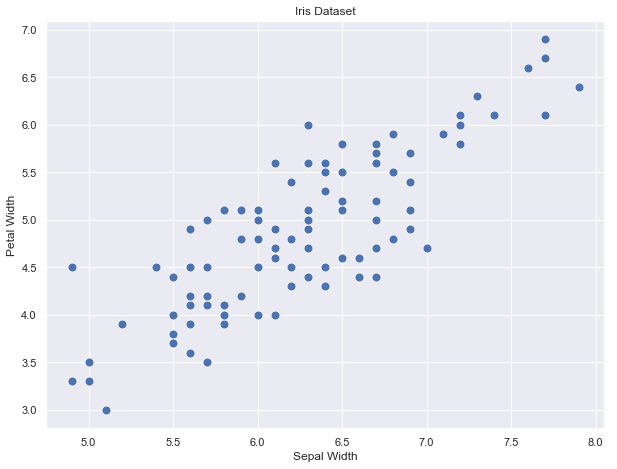

In [405]:
fig,ax = plt.subplots(figsize=(10,7.5))
ax = sns.scatterplot(x="sepal_length", y="petal_length", data=df,s=80)
plt.title("Iris Dataset")
plt.xlabel("Sepal Width")
plt.ylabel("Petal Width")
plt.show()

In [433]:
class Layer(object):
    def __init__(self):
        pass
    
    def compile(self):
        pass
    
    def activate(self,x):
        pass

class InputLayer(Layer):
    def __init__(self,input_dim):
        self.input_dim = input_dim
        self.units = input_dim
    
    def activate(self,x):
        return x
    
class DenseLayer(Layer):
    def __init__(self,units,activation='relu'):
        self.weights = []
        self.bias = None
        self.units = units
        self.input_dim = 0
        self.activation = activation
        self.lastActivation = np.zeros(units)
            
    def compile(self):
        # Create weights
        self.weights = np.random.rand(self.input_dim,self.units) / 5
        self.bias = np.random.rand(self.units) / 5
            
    def activate(self,x):
        o = np.dot(x,self.weights)
        o += self.bias
        if(self.activation == 'relu'):
            o = self.relu(o)
        elif(self.activation == 'sigmoid'):
            o = self.sigmoid(o)
        elif(self.activation == 'lu'):
            o = self.lu(o)
        self.lastActivation = o
        return o
    
    def get_gradient(self,output):
        if(self.activation == 'relu'):
            return self.relu_grad(output)
        elif(self.activation == 'sigmoid'):
            return self.sigmoid_grad(output)
        elif(self.activation == 'lu'):
            return self.lu_grad(output)
        
    def sigmoid(self,x):
        return 1.0 / (1.0 + np.exp(-x))
    def relu(self,x):
        return np.maximum(0,x)
    def tanh(self,x):
        return x
    def lu(self,x):
        return x
    
    def sigmoid_grad(self,output):
        return output * (1.0 - output)
    def tanh_grad(self,output):
        return output
    def lu_grad(self,output):
        return 1
    def relu_grad(self,output):
        d = np.array(output.copy())
        d[d < 0] = 0.0
        d[d > 0] = 1.0
        return d

In [434]:
class Model():
    def __init__(self,lr = 0.3,loss_function='mse'):
        self.layers = []
        self.layerCount = 0
        self.lr = lr
        self.loss_function = loss_function
        
    def Add(self,layer):
        if(not isinstance(layer,Layer)):
            raise Exception("Parameter should be type of Layer.")
        
        if(self.layerCount == 0 and not isinstance(layer,InputLayer)):
            raise Exception("First Layer should be type of Input Layer.")
        
        self.layers.append(layer)
        self.layerCount += 1
        
    def compile(self):
        # Infer layer input dimensions
        for i in range(1,self.layerCount):
            dim = self.layers[i - 1].units
            self.layers[i].input_dim = dim
            self.layers[i].compile()
    
    def train(self,X,y,epoch = 10):
        
        history = pd.DataFrame({'epoch':[None],'loss':[None]})

        for e in range(0,epoch):
            error = 0
            for row,target in zip(X,y):
                error += self.backPropagate(row,target)
            loss = np.mean(error)
            if(e > 2):
                history.loc[history.shape[0]] = [e,loss]
            if(e % 20 == 0):
                print(f'Epoch: {e}, {self.loss_function}: {loss}')
        
        return history
        
    def loss(self,error):
        if(self.loss_function == 'mse'):
            return np.mean(np.square(error))
    
    def predict(self,x):
        return self.feedForward(x)
        
    def feedForward(self,x):
        for layer in self.layers:
            x = layer.activate(x)
        return np.array(x)
    
    def backPropagate(self,x,y):
                
        output_layer = self.layers[-1]
        
        output = self.feedForward(x)
        output_error = y - output # compute error
        output_delta = output_error * output_layer.get_gradient(output)
        
        output_layer.delta = np.array(output_delta)
                
        for i in range(self.layerCount - 2,0,-1):
            nextLayer = self.layers[i +  1]
            currentLayer = self.layers[i]                
            
            w2 = nextLayer.weights
            d2 = nextLayer.delta

            error = np.dot(d2,w2.T)
            
            g = currentLayer.get_gradient(currentLayer.lastActivation)

            delta = error * g
            currentLayer.delta = delta          
        
        for i in range(self.layerCount - 2,0,-1):
            nextLayer = self.layers[i +  1]
            currentLayer = self.layers[i]                
            w = nextLayer.weights
            for n in range(0,w.shape[1]):
                w[:,n] += self.lr * nextLayer.delta[n] * currentLayer.lastActivation[n] 
            nextLayer.weights = w
            nextLayer.bias += self.lr * nextLayer.delta
            #for k in range(0,nextLayer.units):
             #   w = nextLayer.weights
              #  w += self.lr * np.dot(nextLayer.delta[k],currentLayer.lastActivation)
               # nextLayer.weights = w
                #nextLayer.bias += self.lr * nextLayer.delta[k]
        return np.sum(output_error**2)


Epoch: 0, mse: 64.78261393613056
Epoch: 20, mse: 30.929901606165814
Epoch: 40, mse: 29.439866168283903
Epoch: 60, mse: 29.015472845461613
Epoch: 80, mse: 28.896981930906286
Epoch: 100, mse: 28.767174236808827
Epoch: 120, mse: 28.684325896094013
Epoch: 140, mse: 28.679158164900944
Epoch: 160, mse: 28.639567671121526
Epoch: 180, mse: 28.60898677534256
Epoch: 200, mse: 28.53479212496668
Epoch: 220, mse: 28.512391164783587
Epoch: 240, mse: 28.503462359762075
Epoch: 260, mse: 28.492721469788467
Epoch: 280, mse: 28.472203683460403
Epoch: 300, mse: 28.44937376069263
Epoch: 320, mse: 28.451606234790237
Epoch: 340, mse: 28.390902366492373
Epoch: 360, mse: 28.410452758099403
Epoch: 380, mse: 28.37682780480543
Epoch: 400, mse: 28.333627200903443
Epoch: 420, mse: 28.34517965048772
Epoch: 440, mse: 28.31936273396167


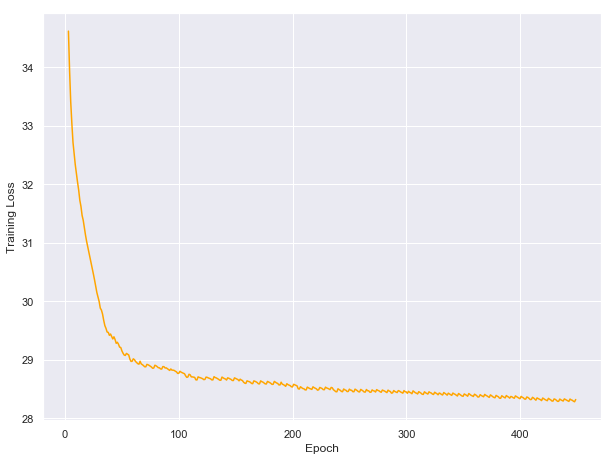

In [422]:
m = Model(lr=0.05)

m.Add(InputLayer(input_dim=1))
m.Add(DenseLayer(128,activation='relu'))
m.Add(DenseLayer(64,activation='relu'))
m.Add(DenseLayer(1,activation='lu'))

m.compile()

history = m.train(x_train,y_train,450)

fig = plt.figure(figsize=(10,7.5))
ax = sns.lineplot(x='epoch',y='loss',color='orange',data=history)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

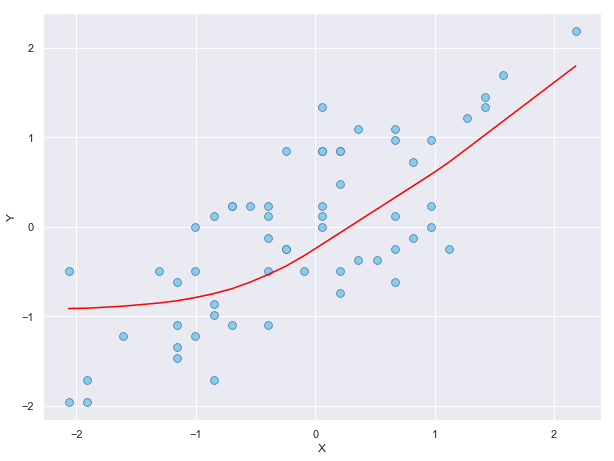

In [423]:
fit = pd.DataFrame({'x':[],'pred':[],'y':[]})

for _x,_y in zip(x_train,y_train):
    pred = m.predict(_x)
    fit.loc[fit.shape[0]] = [_x[0],pred.flatten()[0],_y]
    
    
fig = plt.figure(figsize=(10,7.5))
ax = sns.scatterplot(x='x',y='y',color='skyblue',s=60,edgecolor='b',data=fit)
ax = sns.lineplot(x='x',y='pred',color='red',data=fit)

plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [440]:
dataset = "data_regression1.txt"
df2 = pd.read_csv(dataset,delimiter=',',header=None,names=['feature','output'])

X = df2['feature'].values.reshape(-1,1)
Y = df2['output'].values.reshape(-1,1)

scaler = preprocessing.MinMaxScaler()

X = scaler.fit_transform(X)
Y = scaler.fit_transform(Y)

Epoch: 0, mse: 30.97793948178036
Epoch: 20, mse: 12.134536952299978
Epoch: 40, mse: 12.107142531971128
Epoch: 60, mse: 12.081390788474739
Epoch: 80, mse: 12.057165045648606


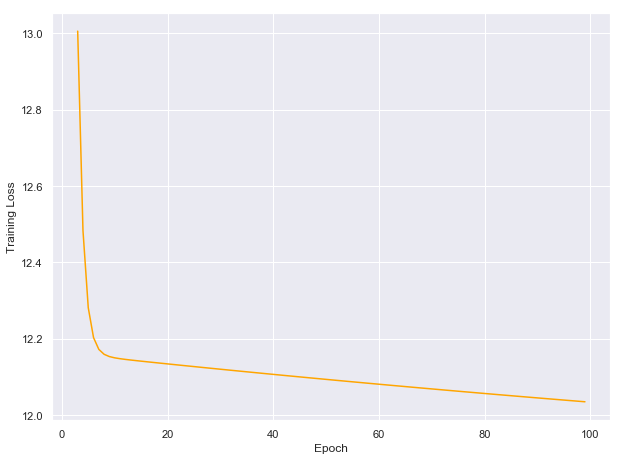

In [443]:
m = Model(lr=0.01)

m.Add(InputLayer(input_dim=1))
m.Add(DenseLayer(32,activation='relu'))
m.Add(DenseLayer(32,activation='relu'))
m.Add(DenseLayer(1,activation='lu'))

m.compile()

history2 = m.train(X,Y,100)

fig = plt.figure(figsize=(10,7.5))
ax = sns.lineplot(x='epoch',y='loss',color='orange',data=history2)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

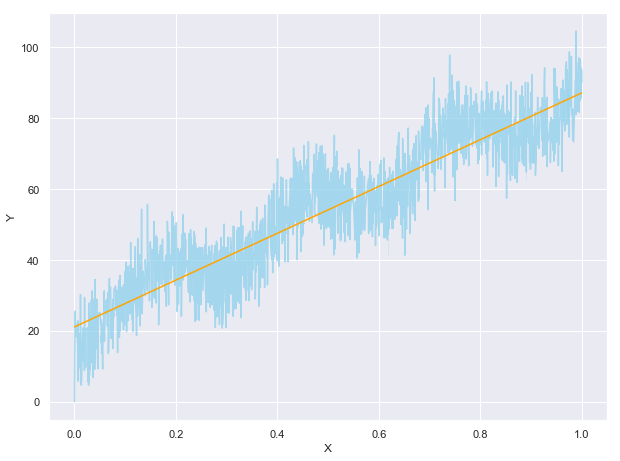

In [444]:
fit = pd.DataFrame({'x':[],'pred':[],'y':[]})

for _x,_y in zip(X,Y):
    pred = m.predict(_x)
    fit.loc[fit.shape[0]] = [_x[0],pred[0] * mx,_y[0] * mx]
    
fig = plt.figure(figsize=(10,7.5))
ax = sns.lineplot(x='x',y='y',color='skyblue',alpha=0.7,data=fit)
ax = sns.lineplot(x='x',y='pred',color='orange',data=fit)

plt.xlabel('X')
plt.ylabel('Y')
plt.show()